## 1-1

In [1]:
# 사용하기 위한 라이브러리와 모듈 불러오기

import os # 파일, 디렉토리 작업 때 사용하는 모듈
import torch # pytorch 사용하기 위한 모듈
import random # 랜덤 모듈, 랜덤 값을 생성할 때 사용하는 모듈
import torchvision # 컴비터 비전 관련 모듈
import torchvision.transforms as transforms # 데이터 전처리 관련 모듈
# 데이터 로딩을 위한 dataloader,학습에서 특정 클래스나 데이터만을 사용해야 할 때, 사용하는 라이브러리
from torch.utils.data import DataLoader, Subset

import torch.nn as nn # 레이어 정의
import torch.optim as optim # 최적화 모듈
import torch.nn.functional as F # activation 모듈
from tqdm import tqdm # 진행사항 표시 모듈

from sklearn.manifold import TSNE # 차원 축소 기법 tsne 사용하기 위한 모듈
from matplotlib.colors import ListedColormap # 색상 리스트를 부르기 위한 모듈
import matplotlib.pyplot as plt # 데이터 시각화, 그래프 그리는 모듈
import numpy as np # numpy 라이브러리

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Seed 고정
set_seed(777)

In [3]:
class ResnetBlock(nn.Module):
    def __init__(self, input_c, output_c, stride = 1):
        # resnetblock 함수
        # input_c = 입력 채널, output_c = 출력 채널, stride = stride 크기
        super(ResnetBlock, self).__init__()
        
        # 첫 번째 convolution layer = 3 x 3 커널, padding = 1을 이용해서 입력과 동일한 크기 출력을 만듦
        self.conv1 = nn.Conv2d(input_c, output_c, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(output_c)
        
        # 두 번째 convolution layer = 3 x 3 커널, padding = 1을 이용해서 입력과 동일한 크기 출력을 만듦
        self.conv2 = nn.Conv2d(output_c, output_c, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(output_c)
        
        # skip connection
        # 입력과 출력의 차원이 다르거나 stride가 1이 아닐 때, skip connection 추가
        self.skip = nn.Sequential()
        if stride != 1 or input_c != output_c:
            # 입력의 차원을 맞추기 위해 1 x 1 conv layer 사용
            self.skip = nn.Sequential(
                nn.Conv2d(input_c, output_c, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(output_c)
            )
            
    def forward(self, x):
        # relu
        output = F.relu(self.bn1(self.conv1(x)))
        
        # batchnorm
        output = self.bn2(self.conv2(output))
        
        # skip connection
        output += self.skip(x)
        
        # relu
        output = F.relu(output)
        
        return output

In [4]:
class Resnet(nn.Module):
    def __init__(self, block, num_blocks, num_classes = 10):
        # block = resnet 블록, num_blocks = 각 layer에서 사용할 블럭의 수, num_classes = cifar10  클래스 수
        super(Resnet, self).__init__()
        # 입력 채널 수
        self.input_c = 64
        
        # 첫 번째 convolution layer = 3 x 3 커널, 입력 채널은 cifar10이 rgb 이미지 이므로 3, 출력은 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # 각 레이어를 만들기 위한 블록 구성
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride = 1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride = 2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride = 2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride = 2)
        
        self.linear = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, output_c, num_blocks, stride):
        # 레이어를 구성하는 함수
        # block = 사용할 블록, output_c = 출력 채널, num_blocks = 레이어에서 사용할 블록 수
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            # resnet 블록 추가하고 입력 채널 수를 업데이트
            layers.append(block(self.input_c, output_c, stride))
            # 다음 블록의 입력 채널 수는 현재 출력 채널 수와 동일
            self.input_c = output_c
            
        # 레이어를 순차적으로 변환
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # 순전파
        # relu
        output = F.relu(self.bn1(self.conv1(x)))
        
        # 각 레이어를 차례대로 통과 --> 연결된 블록들
        output = self.layer1(output)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        
        # average pooling = 출력 텐서 크기를 줄임 (4 x 4)
        output = F.avg_pool2d(output, 4)
        
        # 출력을 1차원 벡터로 변환
        output = output.view(output.size(0), -1)
    
        output = self.linear(output)
        
        return output

In [5]:
def ResNet18():
    # resnet18 모델을 생성하는 함수
    # resnet18 구조는 4개의 layer 그룹으로 되어 있는데, 각 그룹은 2개의 resnetblock을 포함
    
    # resnet 클래스를 호출해서 resnet18 모델을 만들고 반환
    # resnetblock = resnet 블록 구조를 정의하는 클래스
    # [2, 2, 2, 2] = 각 layer 그룹에서 사용할 resnetblock의 수
    return Resnet(ResnetBlock, [2, 2, 2, 2])

In [6]:
# data augmentation
train_transform = transforms.Compose([
    # 이미지를 tensor로 변환, 이미지 값이 0~1 사이로 스케일링
    transforms.ToTensor(),
    # 이미지의 RGB 채널 값을 평균, 표준편차로 정규화
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
# cifar10 데이터 다운로드

train_dataset = torchvision.datasets.CIFAR10(root = './Boundary_Unlearning_task_data', train = True, download = True, transform = train_transform)
test_dataset = torchvision.datasets.CIFAR10(root = './Boundary_Unlearning_task_data', train = False, download = True, transform = test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers = 4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = False, num_workers = 4)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
len(train_dataset), len(test_dataset)

(50000, 10000)

In [9]:
# gpu가 사용 가능한지 확인 --> 가능하면 첫 번째 gpu를 사용하고 아니면 cpu 사용
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
def extract_emb(model, dataloader, device):
    # 모델을 평가모드로 설정 --> 학습 중에 발생하는 것 비활성화 ex) batch normalization
    model.eval()
    emb = []
    all_label = []
    
    # 모델이 가중치를 업데이트 하지 않도록 설정
    with torch.no_grad():
        for batch_images, batch_labels in dataloader:
            # 데이터와 정답 정보들을 정한 device로 이동 --> cpu or gpu
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
            
            # 모델을 통해서 결과값 추출
            features = model(batch_images)
            
            # 결과값 저장
            emb.append(features.cpu().numpy())
            all_label.append(batch_labels.cpu().numpy())
            
    # 모든 배치의 데이터를 연결해서 numpy 배열로 변환
    emb = np.concatenate(emb)
    all_label = np.concatenate(all_label)
    
    return emb, all_label

In [11]:
def visualization_emb_original(embs, labels):
    # tsne를 사용해서 2차원으로 데이터 차원 축소
    tsne = TSNE(n_components = 2, random_state = 7777)
    
    # 추출한 feature embedding을 차원 축소
    reduced_data = tsne.fit_transform(embs)
    
    # 그래프 크기
    plt.figure(figsize=(16, 12))
    # 축소한 데이터를 2차원으로 시각화 --> 점으로 시각화
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c = labels, cmap = 'tab10', alpha = 0.4)
    # plt.colorbar(scatter)
    plt.axis('off')
    plt.title('cifar10_using_10_classes_original')
    plt.show()

start training epoch  1


100%|██████████| 157/157 [00:04<00:00, 39.10it/s]


epoch [epoch][1 / 30], train_loss : 1.7849, train_accuracy : 36.3320, test_loss : 1.4886, test_accuracy : 45.5600%
new acc : 45.56%, save model !
start training epoch  2


100%|██████████| 157/157 [00:04<00:00, 38.73it/s]


epoch [epoch][2 / 30], train_loss : 1.2026, train_accuracy : 56.7340, test_loss : 1.0661, test_accuracy : 62.4100%
new acc : 62.41%, save model !
start training epoch  3


100%|██████████| 157/157 [00:04<00:00, 38.78it/s]


epoch [epoch][3 / 30], train_loss : 0.8928, train_accuracy : 68.4260, test_loss : 0.8554, test_accuracy : 69.8200%
new acc : 69.82%, save model !
start training epoch  4


100%|██████████| 157/157 [00:04<00:00, 37.84it/s]


epoch [epoch][4 / 30], train_loss : 0.7242, train_accuracy : 74.3340, test_loss : 0.8023, test_accuracy : 72.8800%
new acc : 72.88%, save model !
start training epoch  5


100%|██████████| 157/157 [00:04<00:00, 38.65it/s]


epoch [epoch][5 / 30], train_loss : 0.5783, train_accuracy : 79.6740, test_loss : 0.6514, test_accuracy : 77.5100%
new acc : 77.51%, save model !
start training epoch  6


100%|██████████| 157/157 [00:04<00:00, 38.76it/s]


epoch [epoch][6 / 30], train_loss : 0.4599, train_accuracy : 83.7460, test_loss : 0.6785, test_accuracy : 76.8600%
start training epoch  7


100%|██████████| 157/157 [00:04<00:00, 38.87it/s]


epoch [epoch][7 / 30], train_loss : 0.3532, train_accuracy : 87.5300, test_loss : 0.6294, test_accuracy : 80.7700%
new acc : 80.77%, save model !
start training epoch  8


100%|██████████| 157/157 [00:04<00:00, 38.77it/s]


epoch [epoch][8 / 30], train_loss : 0.2707, train_accuracy : 90.4660, test_loss : 0.6784, test_accuracy : 79.3600%
start training epoch  9


100%|██████████| 157/157 [00:04<00:00, 37.80it/s]


epoch [epoch][9 / 30], train_loss : 0.1963, train_accuracy : 92.9920, test_loss : 0.7035, test_accuracy : 80.9000%
new acc : 80.90%, save model !
start training epoch  10


100%|██████████| 157/157 [00:04<00:00, 38.97it/s]


epoch [epoch][10 / 30], train_loss : 0.1427, train_accuracy : 94.9280, test_loss : 0.6935, test_accuracy : 81.9300%
new acc : 81.93%, save model !
visualization decision space 10


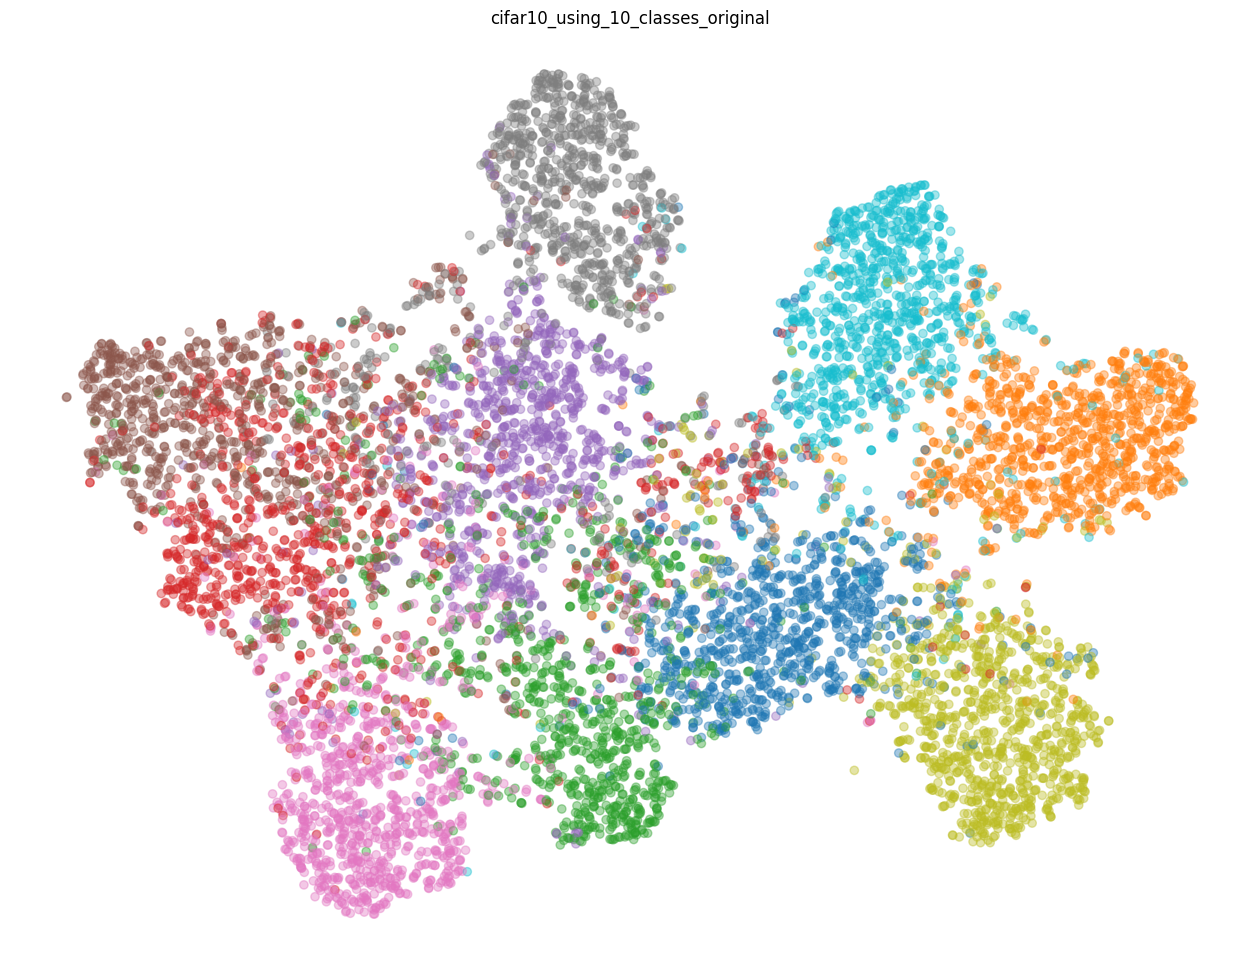

start training epoch  11


100%|██████████| 157/157 [00:04<00:00, 38.69it/s]


epoch [epoch][11 / 30], train_loss : 0.1090, train_accuracy : 96.0920, test_loss : 0.7859, test_accuracy : 80.7000%
start training epoch  12


100%|██████████| 157/157 [00:04<00:00, 38.72it/s]


epoch [epoch][12 / 30], train_loss : 0.0763, train_accuracy : 97.3220, test_loss : 0.8922, test_accuracy : 81.2800%
start training epoch  13


100%|██████████| 157/157 [00:04<00:00, 38.84it/s]


epoch [epoch][13 / 30], train_loss : 0.0673, train_accuracy : 97.6620, test_loss : 0.8094, test_accuracy : 82.1800%
new acc : 82.18%, save model !
start training epoch  14


100%|██████████| 157/157 [00:04<00:00, 38.53it/s]


epoch [epoch][14 / 30], train_loss : 0.0502, train_accuracy : 98.2700, test_loss : 0.9567, test_accuracy : 80.6900%
start training epoch  15


100%|██████████| 157/157 [00:04<00:00, 38.55it/s]


epoch [epoch][15 / 30], train_loss : 0.0425, train_accuracy : 98.5440, test_loss : 0.9488, test_accuracy : 81.8900%
start training epoch  16


100%|██████████| 157/157 [00:04<00:00, 38.86it/s]


epoch [epoch][16 / 30], train_loss : 0.0332, train_accuracy : 98.8360, test_loss : 0.9598, test_accuracy : 81.6300%
start training epoch  17


100%|██████████| 157/157 [00:04<00:00, 38.33it/s]


epoch [epoch][17 / 30], train_loss : 0.0326, train_accuracy : 98.9360, test_loss : 0.9252, test_accuracy : 82.1700%
start training epoch  18


100%|██████████| 157/157 [00:04<00:00, 38.80it/s]


epoch [epoch][18 / 30], train_loss : 0.0232, train_accuracy : 99.2180, test_loss : 0.9628, test_accuracy : 82.2100%
new acc : 82.21%, save model !
start training epoch  19


100%|██████████| 157/157 [00:04<00:00, 38.20it/s]


epoch [epoch][19 / 30], train_loss : 0.0191, train_accuracy : 99.3620, test_loss : 1.0304, test_accuracy : 82.3200%
new acc : 82.32%, save model !
start training epoch  20


100%|██████████| 157/157 [00:04<00:00, 38.91it/s]


epoch [epoch][20 / 30], train_loss : 0.0173, train_accuracy : 99.4000, test_loss : 0.9804, test_accuracy : 82.7600%
new acc : 82.76%, save model !
visualization decision space 20


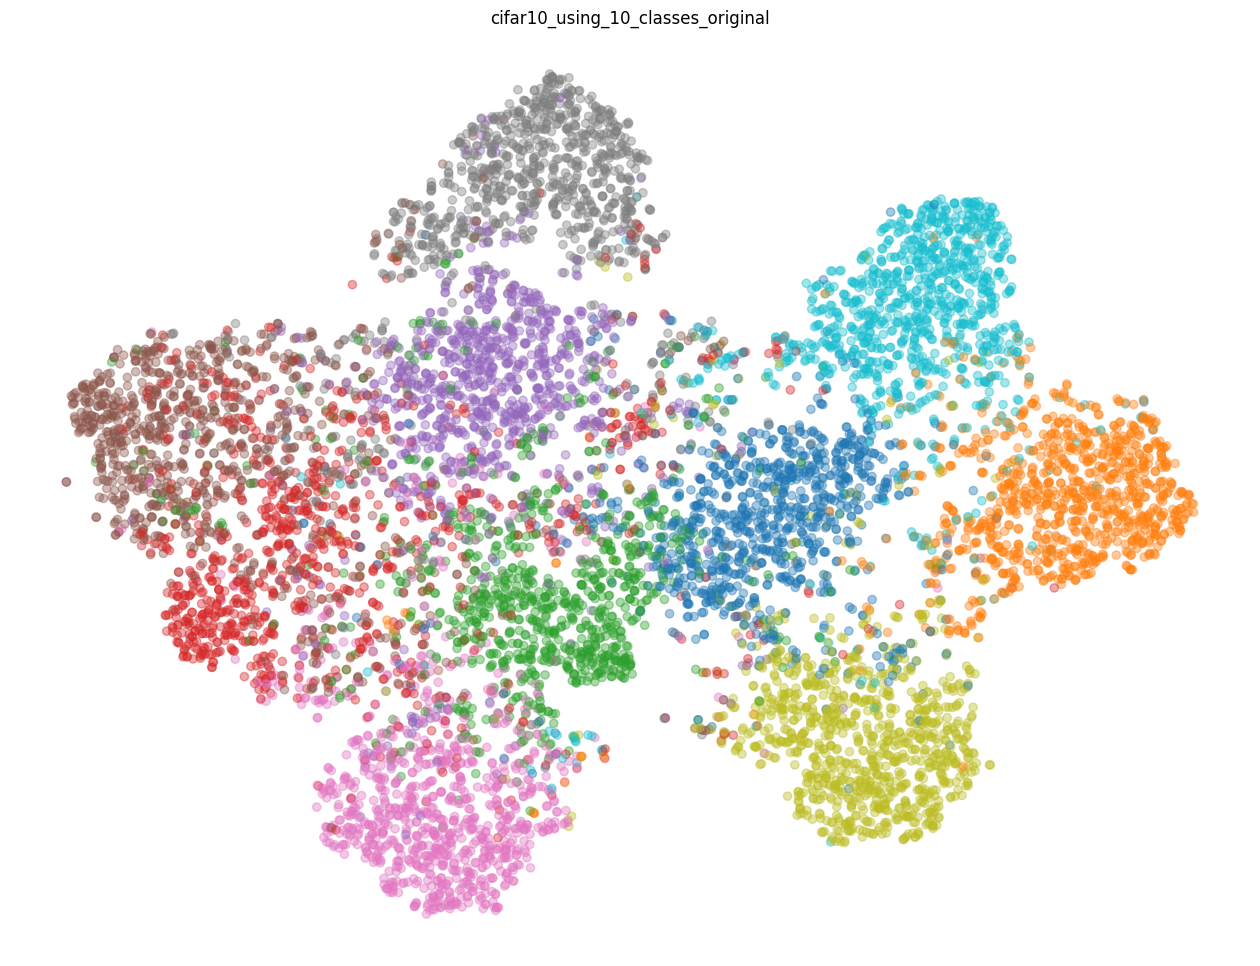

start training epoch  21


100%|██████████| 157/157 [00:04<00:00, 38.76it/s]


epoch [epoch][21 / 30], train_loss : 0.0146, train_accuracy : 99.5080, test_loss : 1.0015, test_accuracy : 83.2600%
new acc : 83.26%, save model !
start training epoch  22


100%|██████████| 157/157 [00:04<00:00, 38.49it/s]


epoch [epoch][22 / 30], train_loss : 0.0116, train_accuracy : 99.6280, test_loss : 1.0048, test_accuracy : 82.5600%
start training epoch  23


100%|██████████| 157/157 [00:04<00:00, 38.71it/s]


epoch [epoch][23 / 30], train_loss : 0.0157, train_accuracy : 99.4600, test_loss : 1.0474, test_accuracy : 82.7600%
start training epoch  24


100%|██████████| 157/157 [00:04<00:00, 38.41it/s]


epoch [epoch][24 / 30], train_loss : 0.0099, train_accuracy : 99.6760, test_loss : 1.0063, test_accuracy : 83.7700%
new acc : 83.77%, save model !
start training epoch  25


100%|██████████| 157/157 [00:04<00:00, 38.61it/s]


epoch [epoch][25 / 30], train_loss : 0.0093, train_accuracy : 99.6900, test_loss : 1.0911, test_accuracy : 82.9500%
start training epoch  26


100%|██████████| 157/157 [00:04<00:00, 38.50it/s]


epoch [epoch][26 / 30], train_loss : 0.0114, train_accuracy : 99.5980, test_loss : 1.0534, test_accuracy : 82.3500%
start training epoch  27


100%|██████████| 157/157 [00:04<00:00, 38.83it/s]


epoch [epoch][27 / 30], train_loss : 0.0078, train_accuracy : 99.7640, test_loss : 1.0541, test_accuracy : 83.2100%
start training epoch  28


100%|██████████| 157/157 [00:04<00:00, 38.54it/s]


epoch [epoch][28 / 30], train_loss : 0.0051, train_accuracy : 99.8280, test_loss : 1.0645, test_accuracy : 83.9300%
new acc : 83.93%, save model !
start training epoch  29


100%|██████████| 157/157 [00:04<00:00, 38.86it/s]


epoch [epoch][29 / 30], train_loss : 0.0072, train_accuracy : 99.7980, test_loss : 1.0646, test_accuracy : 83.6500%
start training epoch  30


100%|██████████| 157/157 [00:04<00:00, 38.63it/s]

epoch [epoch][30 / 30], train_loss : 0.0110, train_accuracy : 99.6380, test_loss : 1.0094, test_accuracy : 83.5800%
visualization decision space 30


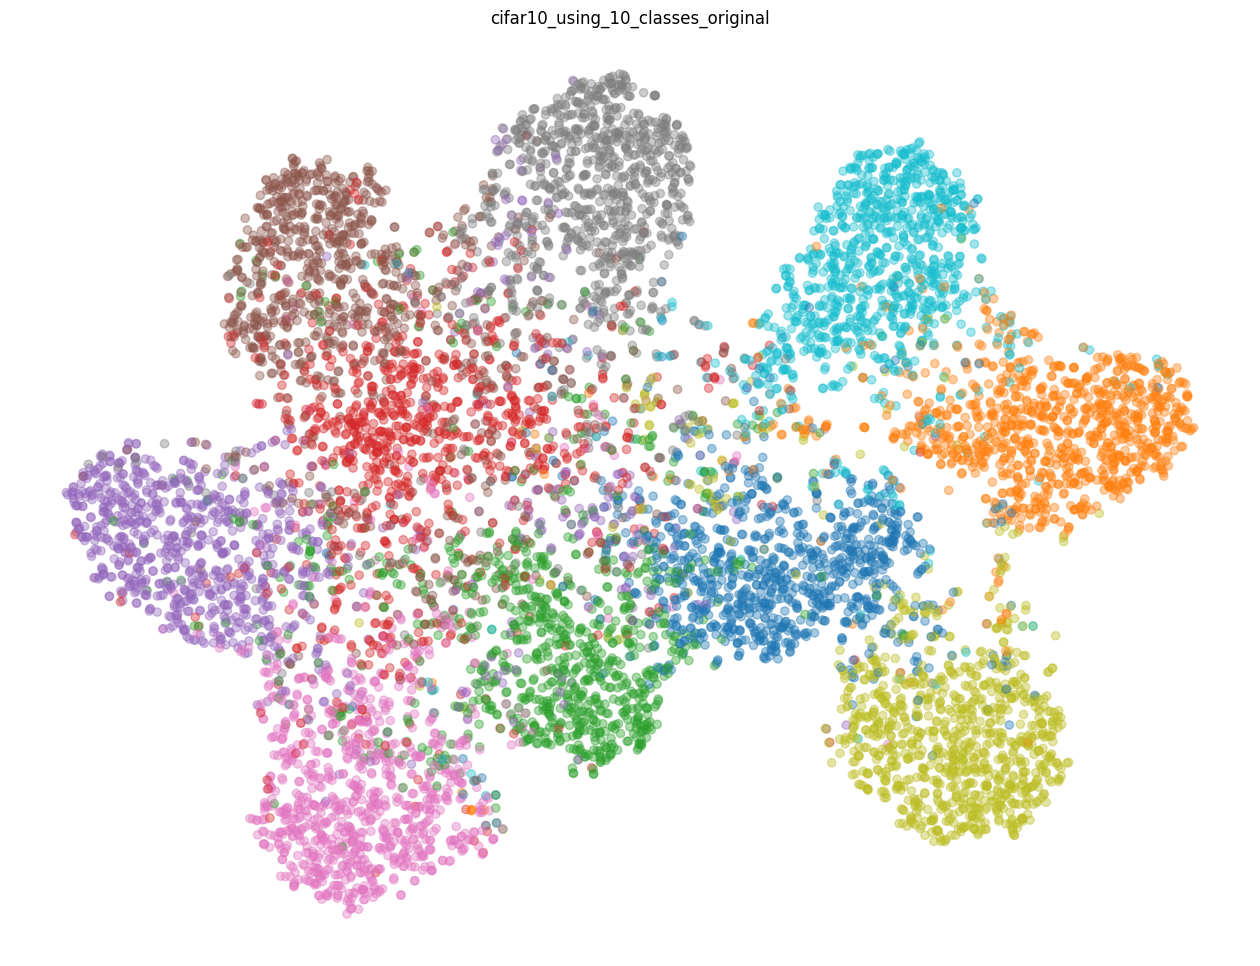

In [12]:
# 모델을 선언
model = ResNet18().to(device)

# pt를 저장하기 위한 폴더 생성
pt_folder_name = 'Boundary_Unlearning_task1_pt'
os.makedirs(pt_folder_name, exist_ok = True)

# 모델의 가장 높은 정확도를 기록하기 위한 변수
best_accuracy = 0.

# 분류 문제에서 자주 사용하는 손실 함수
criterion = nn.CrossEntropyLoss()

# Stochastic Gradient Descent = 확률 경사 하강법
optimizer = optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9)

# 학습 수 30 회
for epoch in range(1, 31):
    print("start training epoch ", epoch)
    
    # 학습 모드 설정, loss, 맞춘 수, 사용한 샘플 수
    model.train()
    train_total_loss = 0.
    train_total_count = 0.
    train_total_data = 0
    
    # 학습 데이터를 배치 단위로 로드, tqdm으로 진행 상황 출력
    for idx, (images, labels) in enumerate(tqdm(train_loader)):
        # 학습할 device로 보내기
        images, labels = images.to(device), labels.to(device)
        
        # 이전 배치에서 계산된 기울기 값 초기화
        optimizer.zero_grad()
        
        # 입력 데이터에 대한 예측
        logit_output = model(images)
        
        # 예측된 출력과 정답 간의 차이 계산
        loss = criterion(logit_output, labels)
        
        # 모델이 예측한 정답
        _, predict = torch.max(logit_output, 1)
        
        # 예측이 실제 정답과 일치하는 수
        check_count = (predict == labels).sum().item()
        
        train_total_loss += loss.item()
        train_total_count += check_count
        train_total_data += len(labels)
        
        # loss에 대한 모델의 가중치의 기울기 계싼
        loss.backward()
        # 계산한 기울기를 이용하여 가중치 업데이터
        optimizer.step()
        # 기울기 초기화 후 다음 배치 준비
        model.zero_grad()
        
    # 학습 배치에서의 loss
    train_avg_loss = train_total_loss / len(train_loader)
    # 학습 배치에서의 정확도
    train_accuracy = train_total_count / train_total_data * 100
        
    # 평가 모드 설정, loss, 맞춘 수, 사용한 샘플 수
    model.eval()
    test_total_loss = 0.
    test_total_count = 0.
    test_total_data = 0
    
    # 테스트 데이터를 배치 단위로 로드, tqdm으로 진행 상황 출력
    for idx, (images, labels) in enumerate(tqdm(test_loader)):
        
        images, labels = images.to(device), labels.to(device)
        
        # 기울기 계산을 사용하지 않음
        with torch.no_grad():
            # 테스트 데이터로 모델의 예측값을 얻음
            logit_output = model(images)
            
            # 예측과 정답 사이의 loss 계산
            loss = criterion(logit_output, labels)
            
            # 모델이 예측한 정답을 얻음
            _, predict = torch.max(logit_output, 1)
            
            # 맞춘 샘플 수
            check_count = (predict == labels).sum().item()
            
            test_total_loss += loss.item()
            test_total_count += check_count
            test_total_data += len(labels)
    
    # 테스트 데이터에 대한 loss    
    test_avg_loss = test_total_loss / len(test_loader)
    # 테스트 데이터에 대한 정확도
    test_accuracy = test_total_count / test_total_data * 100
    
    print(f"epoch [epoch][{epoch} / 30], train_loss : {train_avg_loss:.4f}, train_accuracy : {train_accuracy:.4f}, test_loss : {test_avg_loss:.4f}, test_accuracy : {test_accuracy:.4f}%")
    
    # 테스트 정확도가 가장 높은 경우 모델 저장
    if test_accuracy > best_accuracy:
        print(f"new acc : {test_accuracy:.2f}%, save model !")
        best_accuracy = test_accuracy
        # 모델의 가중치를 지정된 경로에 저장
        model_save_path = os.path.join(pt_folder_name, f"resnet18_best_original.pt")
        torch.save(model.state_dict(), model_save_path)
            
    # 시각화 하기 위한 수단
    if epoch == 10 or epoch == 20 or epoch == 30:
        print(f'visualization decision space {epoch}')
        embs, labels = extract_emb(model, test_loader, device)
        visualization_emb_original(embs, labels)

## 1-2

In [13]:
# 잊고자 하는 클래스
forget_class = 0

# forget class에 해당하는 인덱스 저장 --> 클래스 0에 해당하는 데이터 인덱스만 리스트에 저장
train_forgetset_split = [i for i, (_, label) in enumerate(train_dataset) if label == forget_class]
# forget class에 해당하지 않는 인덱스 저장 --> 클래스 0을 제외한 데이터 인덱스만 레스트에 저장
train_remainset_split = [i for i, (_, label) in enumerate(train_dataset) if label != forget_class]

In [14]:
# forget class에 해당하는 인덱스 저장 --> 클래스 0에 해당하는 데이터 인덱스만 리스트에 저장
test_forgetset_split = [i for i, (_, label) in enumerate(test_dataset) if label == forget_class]
# forget class에 해당하지 않는 인덱스 저장 --> 클래스 0을 제외한 데이터 인덱스만 리스트에 저장
test_remainset_split = [i for i, (_, label) in enumerate(test_dataset) if label != forget_class]

In [15]:
# 학습 중 잊어야 하는 데이터만 추출한 데이터셋
train_forgetset = Subset(train_dataset, train_forgetset_split)
# 학습 중 잊어야 하는 데이터를 제외한 데이터셋
train_remainset = Subset(train_dataset, train_remainset_split)
# 테스트 중 잊어야 하는 데이터만 추출한 데이터셋
test_forgetset = Subset(test_dataset, test_forgetset_split)
# 테스트 중 잊어야 하는 데이터를 제외한 데이터셋
test_remainset = Subset(test_dataset, test_remainset_split)

In [16]:
len(train_forgetset), len(train_remainset), len(test_forgetset), len(test_remainset)

(5000, 45000, 1000, 9000)

In [17]:
train_remain_loader = DataLoader(train_remainset, batch_size = 64, shuffle = True)
train_forget_loader = DataLoader(train_forgetset, batch_size = 64, shuffle = True)
test_remain_loader = DataLoader(test_remainset, batch_size = 64, shuffle = False)
test_forget_loader = DataLoader(test_forgetset, batch_size = 64, shuffle = False)

In [18]:
def visualization_emb_retrain(embs, labels):
    # tsne를 사용해서 2차원으로 데이터 차원 축소
    tsne = TSNE(n_components = 2, random_state = 7777)
    
    # 추출한 feature embedding을 차원 축소
    reduced_data = tsne.fit_transform(embs)
    
    # 9개의 클래스를 시각화하기 위해 tab10 컬러맵의 9개만 사용
    cmap = ListedColormap(plt.cm.tab10.colors[:9])
    
    # 그래프 크기
    plt.figure(figsize=(16, 12))
    
    # 축소한 데이터를 2차원으로 시각화 --> 점으로 시각화
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c = labels, cmap = cmap , alpha = 0.4)
    plt.axis('off')
    # plt.colorbar(scatter)
    plt.title('cifar10_using_9_classes_retrain')
    plt.show()

In [19]:
# remain 데이터와 forget 데이터에 대해 시각화 하는 함수
# emb_remain = 남은 데이터
# emb_forget = 잊을 데이터
# remain_labels = 남은 데이터에 맞는 정답
# forget_labels = 잊을 데이터에 맞는 정답

def visualization_emb_com(emb_remain, emb_forget, remain_labels, forget_labels):
    # 남은 데이터와 잊을 데이터를 행 방향으로 합쳐서 배열을 만듦
    comb_emb = np.concatenate([emb_remain, emb_forget], axis = 0)
    comb_label = np.concatenate([remain_labels, forget_labels], axis = 0)
    
    # tsne를 사용해서 2차원으로 데이터 차원 축소
    tsne = TSNE(n_components = 2, random_state = 7777)
    
    # 추출한 feature embedding을 차원 축소
    reduced_data = tsne.fit_transform(comb_emb)
    
    # 남은 데이터는 tab10의 색상 중 9개만 사용
    cmap1 = ListedColormap(plt.cm.tab10.colors[:9])
    # 잊을 데이터는 그 이외의 색상을 사용
    cmap2 = ListedColormap(plt.cm.tab10.colors[9:])
    
    # 그래프 크기
    plt.figure(figsize=(16, 12))
    
    # 축소한 데이터를 2차원으로 시각화 --> 점으로 시각화
    remain_scatter = plt.scatter(reduced_data[:len(emb_remain), 0], reduced_data[:len(emb_remain), 1], 
                                 c = remain_labels, cmap = cmap1, alpha = 0.4, label = 'remain', marker = 'o')
    forget_scatter = plt.scatter(reduced_data[len(emb_remain):, 0], reduced_data[len(emb_remain):, 1], 
                                 c = forget_labels, cmap = cmap2, alpha = 0.8, label = 'forget', marker = 'x')
    
    plt.legend()
    plt.axis('off')
    # plt.colorbar(remain_scatter)
    # plt.colorbar(forget_scatter)
    # plt.colorbar(scatter, ticks = range(10))
    plt.title('cifar10_using_remain_forget_decision_space')
    plt.show()

start training epoch  1


100%|██████████| 141/141 [00:05<00:00, 23.58it/s]


[epoch][1 / 30], train_loss : 1.8823, train_accuracy : 32.3956, test_loss : 1.4732, test_accuracy : 45.1333%
new acc : 45.13%, save model !
start forget_training epoch  1


100%|██████████| 16/16 [00:00<00:00, 24.25it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  2


100%|██████████| 141/141 [00:06<00:00, 23.42it/s]


[epoch][2 / 30], train_loss : 1.3653, train_accuracy : 49.5778, test_loss : 1.2299, test_accuracy : 54.7444%
new acc : 54.74%, save model !
start forget_training epoch  2


100%|██████████| 16/16 [00:00<00:00, 25.06it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  3


100%|██████████| 141/141 [00:05<00:00, 26.34it/s]


[epoch][3 / 30], train_loss : 1.1509, train_accuracy : 57.9267, test_loss : 1.0984, test_accuracy : 60.5000%
new acc : 60.50%, save model !
start forget_training epoch  3


100%|██████████| 16/16 [00:00<00:00, 27.62it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  4


100%|██████████| 141/141 [00:06<00:00, 23.41it/s]


[epoch][4 / 30], train_loss : 0.9598, train_accuracy : 65.2911, test_loss : 1.0316, test_accuracy : 62.8222%
new acc : 62.82%, save model !
start forget_training epoch  4


100%|██████████| 16/16 [00:00<00:00, 25.52it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  5


100%|██████████| 141/141 [00:05<00:00, 23.59it/s]


[epoch][5 / 30], train_loss : 0.8013, train_accuracy : 71.1267, test_loss : 0.8790, test_accuracy : 68.7667%
new acc : 68.77%, save model !
start forget_training epoch  5


100%|██████████| 16/16 [00:00<00:00, 25.32it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  6


100%|██████████| 141/141 [00:05<00:00, 23.63it/s]


[epoch][6 / 30], train_loss : 0.6837, train_accuracy : 75.6711, test_loss : 0.7495, test_accuracy : 73.5444%
new acc : 73.54%, save model !
start forget_training epoch  6


100%|██████████| 16/16 [00:00<00:00, 25.19it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  7


100%|██████████| 141/141 [00:06<00:00, 22.72it/s]


[epoch][7 / 30], train_loss : 0.5913, train_accuracy : 78.9178, test_loss : 0.6951, test_accuracy : 75.7333%
new acc : 75.73%, save model !
start forget_training epoch  7


100%|██████████| 16/16 [00:00<00:00, 24.57it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  8


100%|██████████| 141/141 [00:05<00:00, 23.72it/s]


[epoch][8 / 30], train_loss : 0.4985, train_accuracy : 82.0667, test_loss : 0.7066, test_accuracy : 75.7222%
start forget_training epoch  8


100%|██████████| 16/16 [00:00<00:00, 24.79it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  9


100%|██████████| 141/141 [00:05<00:00, 23.64it/s]


[epoch][9 / 30], train_loss : 0.4181, train_accuracy : 84.8800, test_loss : 0.6710, test_accuracy : 77.4889%
new acc : 77.49%, save model !
start forget_training epoch  9


100%|██████████| 16/16 [00:00<00:00, 25.23it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  10


100%|██████████| 141/141 [00:05<00:00, 23.65it/s]


[epoch][10 / 30], train_loss : 0.3252, train_accuracy : 88.3733, test_loss : 0.7155, test_accuracy : 77.9556%
new acc : 77.96%, save model !
start forget_training epoch  10


100%|██████████| 16/16 [00:00<00:00, 24.82it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
visualization decision space 10


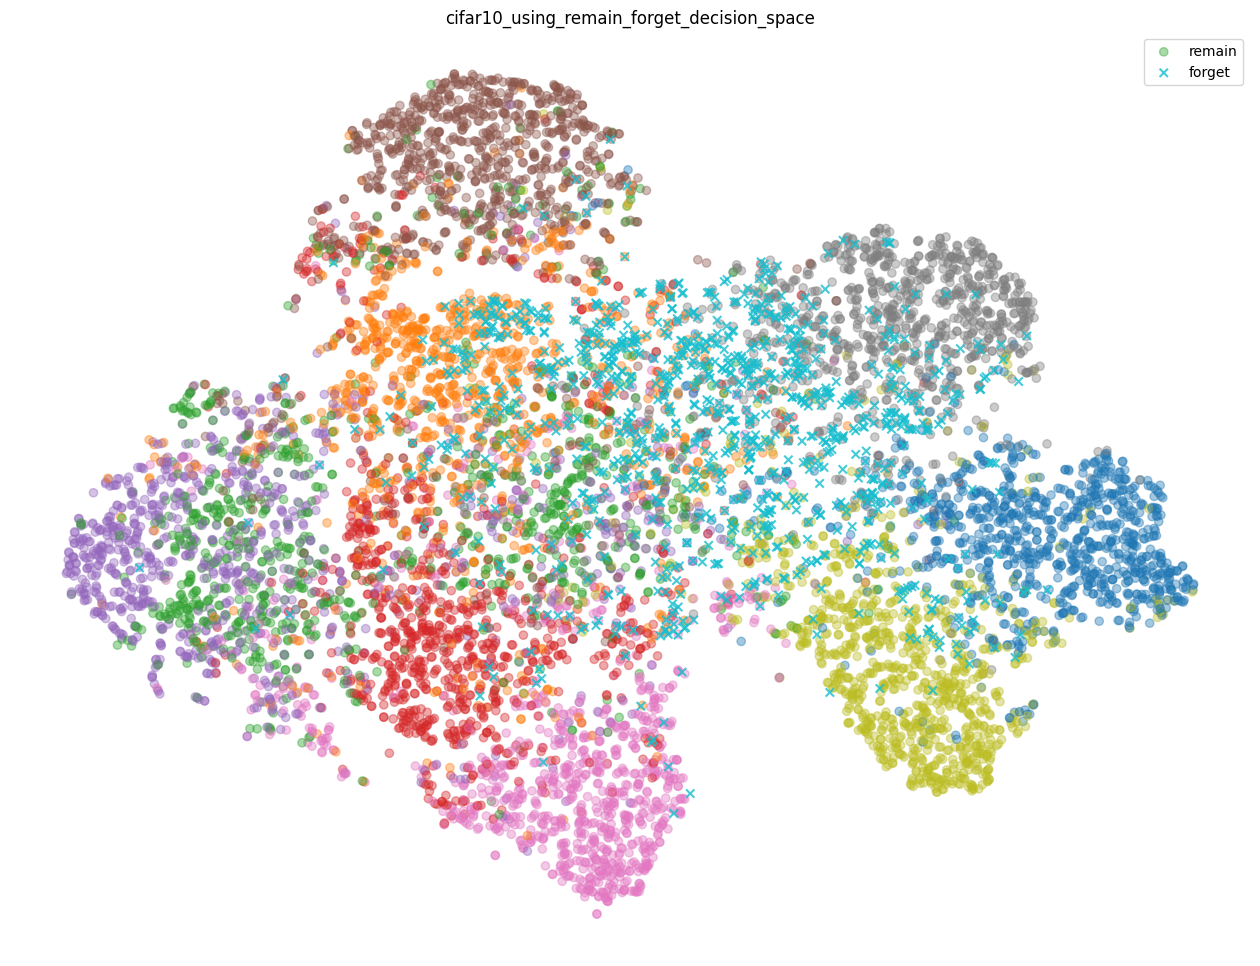

start training epoch  11


100%|██████████| 141/141 [00:06<00:00, 23.15it/s]


[epoch][11 / 30], train_loss : 0.2446, train_accuracy : 91.2400, test_loss : 0.7056, test_accuracy : 78.6444%
new acc : 78.64%, save model !
start forget_training epoch  11


100%|██████████| 16/16 [00:00<00:00, 24.21it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  12


100%|██████████| 141/141 [00:06<00:00, 23.32it/s]


[epoch][12 / 30], train_loss : 0.1752, train_accuracy : 93.7578, test_loss : 0.9384, test_accuracy : 75.9222%
start forget_training epoch  12


100%|██████████| 16/16 [00:00<00:00, 21.52it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  13


100%|██████████| 141/141 [00:06<00:00, 23.24it/s]


[epoch][13 / 30], train_loss : 0.1492, train_accuracy : 94.6844, test_loss : 0.7769, test_accuracy : 78.8333%
new acc : 78.83%, save model !
start forget_training epoch  13


100%|██████████| 16/16 [00:00<00:00, 24.58it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  14


100%|██████████| 141/141 [00:05<00:00, 23.59it/s]


[epoch][14 / 30], train_loss : 0.1027, train_accuracy : 96.4289, test_loss : 0.8023, test_accuracy : 79.8778%
new acc : 79.88%, save model !
start forget_training epoch  14


100%|██████████| 16/16 [00:00<00:00, 24.75it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  15


100%|██████████| 141/141 [00:06<00:00, 22.88it/s]


[epoch][15 / 30], train_loss : 0.0704, train_accuracy : 97.5733, test_loss : 1.0627, test_accuracy : 76.6000%
start forget_training epoch  15


100%|██████████| 16/16 [00:00<00:00, 24.57it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  16


100%|██████████| 141/141 [00:06<00:00, 23.29it/s]


[epoch][16 / 30], train_loss : 0.0824, train_accuracy : 97.1822, test_loss : 0.9542, test_accuracy : 79.7667%
start forget_training epoch  16


100%|██████████| 16/16 [00:00<00:00, 24.19it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  17


100%|██████████| 141/141 [00:06<00:00, 23.45it/s]


[epoch][17 / 30], train_loss : 0.0369, train_accuracy : 98.7667, test_loss : 0.9643, test_accuracy : 80.6111%
new acc : 80.61%, save model !
start forget_training epoch  17


100%|██████████| 16/16 [00:00<00:00, 24.12it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  18


100%|██████████| 141/141 [00:06<00:00, 21.76it/s]


[epoch][18 / 30], train_loss : 0.0370, train_accuracy : 98.6822, test_loss : 0.9552, test_accuracy : 80.1778%
start forget_training epoch  18


100%|██████████| 16/16 [00:00<00:00, 23.88it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  19


100%|██████████| 141/141 [00:06<00:00, 21.81it/s]


[epoch][19 / 30], train_loss : 0.0296, train_accuracy : 99.0467, test_loss : 1.0304, test_accuracy : 80.0000%
start forget_training epoch  19


100%|██████████| 16/16 [00:00<00:00, 24.02it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  20


100%|██████████| 141/141 [00:05<00:00, 23.71it/s]


[epoch][20 / 30], train_loss : 0.0226, train_accuracy : 99.2378, test_loss : 1.0680, test_accuracy : 79.6556%
start forget_training epoch  20


100%|██████████| 16/16 [00:00<00:00, 24.30it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
visualization decision space 20


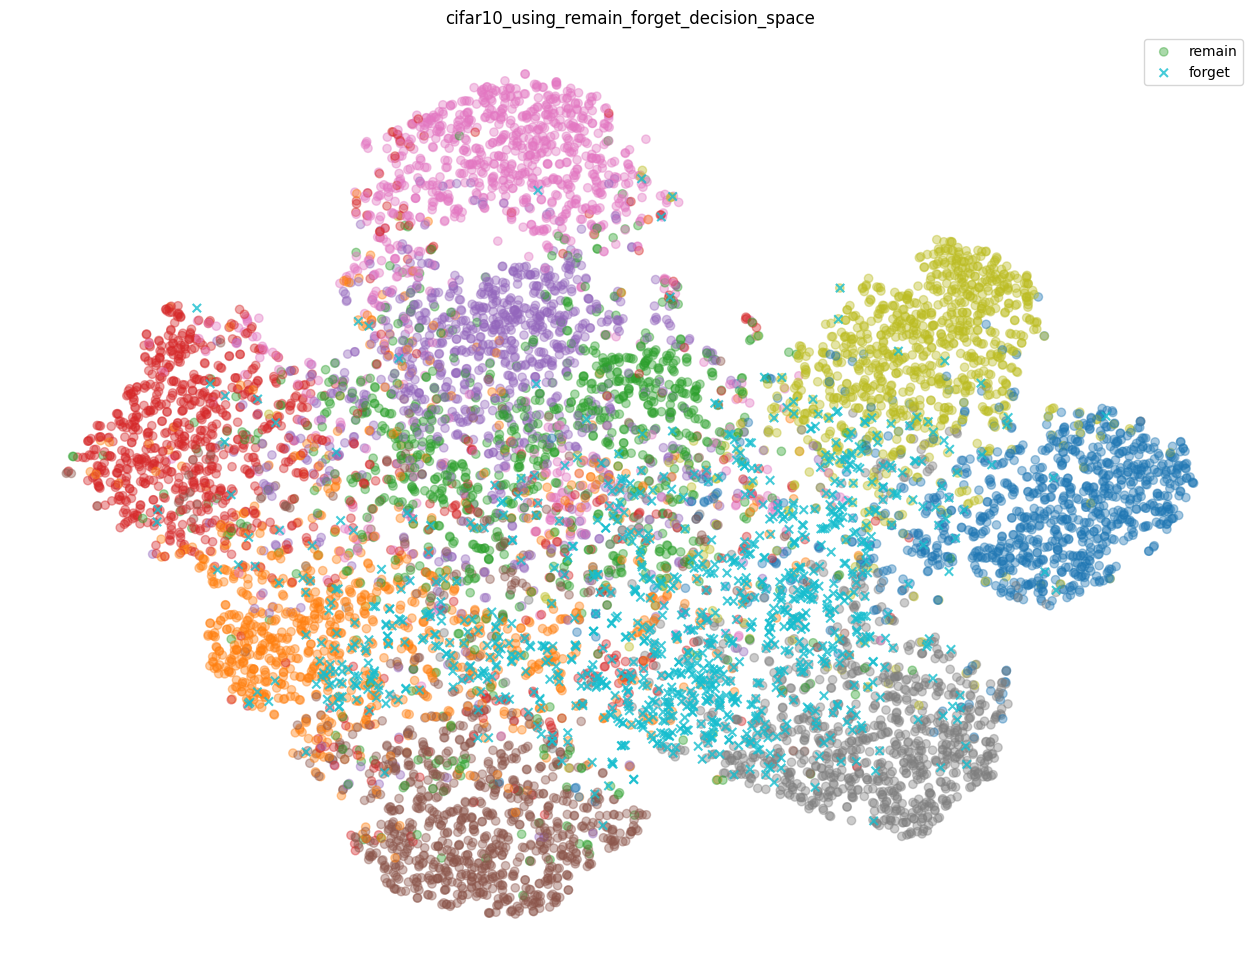

start training epoch  21


100%|██████████| 141/141 [00:05<00:00, 23.50it/s]


[epoch][21 / 30], train_loss : 0.0383, train_accuracy : 98.7000, test_loss : 1.0137, test_accuracy : 80.4222%
start forget_training epoch  21


100%|██████████| 16/16 [00:00<00:00, 25.00it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  22


100%|██████████| 141/141 [00:05<00:00, 24.76it/s]


[epoch][22 / 30], train_loss : 0.0246, train_accuracy : 99.2067, test_loss : 1.1093, test_accuracy : 79.6222%
start forget_training epoch  22


100%|██████████| 16/16 [00:00<00:00, 21.73it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  23


100%|██████████| 141/141 [00:06<00:00, 22.12it/s]


[epoch][23 / 30], train_loss : 0.0274, train_accuracy : 99.0778, test_loss : 1.0721, test_accuracy : 80.1444%
start forget_training epoch  23


100%|██████████| 16/16 [00:00<00:00, 26.52it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  24


100%|██████████| 141/141 [00:05<00:00, 23.54it/s]


[epoch][24 / 30], train_loss : 0.0109, train_accuracy : 99.6689, test_loss : 1.0151, test_accuracy : 81.7222%
new acc : 81.72%, save model !
start forget_training epoch  24


100%|██████████| 16/16 [00:00<00:00, 24.46it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  25


100%|██████████| 141/141 [00:06<00:00, 23.33it/s]


[epoch][25 / 30], train_loss : 0.0051, train_accuracy : 99.8667, test_loss : 1.0254, test_accuracy : 82.7444%
new acc : 82.74%, save model !
start forget_training epoch  25


100%|██████████| 16/16 [00:00<00:00, 24.46it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  26


100%|██████████| 141/141 [00:05<00:00, 25.47it/s]


[epoch][26 / 30], train_loss : 0.0041, train_accuracy : 99.8867, test_loss : 1.0593, test_accuracy : 81.9556%
start forget_training epoch  26


100%|██████████| 16/16 [00:00<00:00, 22.41it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  27


100%|██████████| 141/141 [00:06<00:00, 23.28it/s]


[epoch][27 / 30], train_loss : 0.0025, train_accuracy : 99.9444, test_loss : 1.1116, test_accuracy : 81.7556%
start forget_training epoch  27


100%|██████████| 16/16 [00:00<00:00, 22.99it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  28


100%|██████████| 141/141 [00:05<00:00, 23.50it/s]


[epoch][28 / 30], train_loss : 0.0207, train_accuracy : 99.3311, test_loss : 1.1541, test_accuracy : 81.3000%
start forget_training epoch  28


100%|██████████| 16/16 [00:00<00:00, 24.45it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  29


100%|██████████| 141/141 [00:05<00:00, 23.58it/s]


[epoch][29 / 30], train_loss : 0.0298, train_accuracy : 98.9889, test_loss : 1.0740, test_accuracy : 80.4556%
start forget_training epoch  29


100%|██████████| 16/16 [00:00<00:00, 24.28it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
start training epoch  30


100%|██████████| 141/141 [00:06<00:00, 23.47it/s]


[epoch][30 / 30], train_loss : 0.0320, train_accuracy : 98.9178, test_loss : 1.0136, test_accuracy : 81.7333%
start forget_training epoch  30


100%|██████████| 16/16 [00:00<00:00, 24.38it/s]


forgetset - train accuracy : 0.00%, test accuracy: 0.00
visualization decision space 30


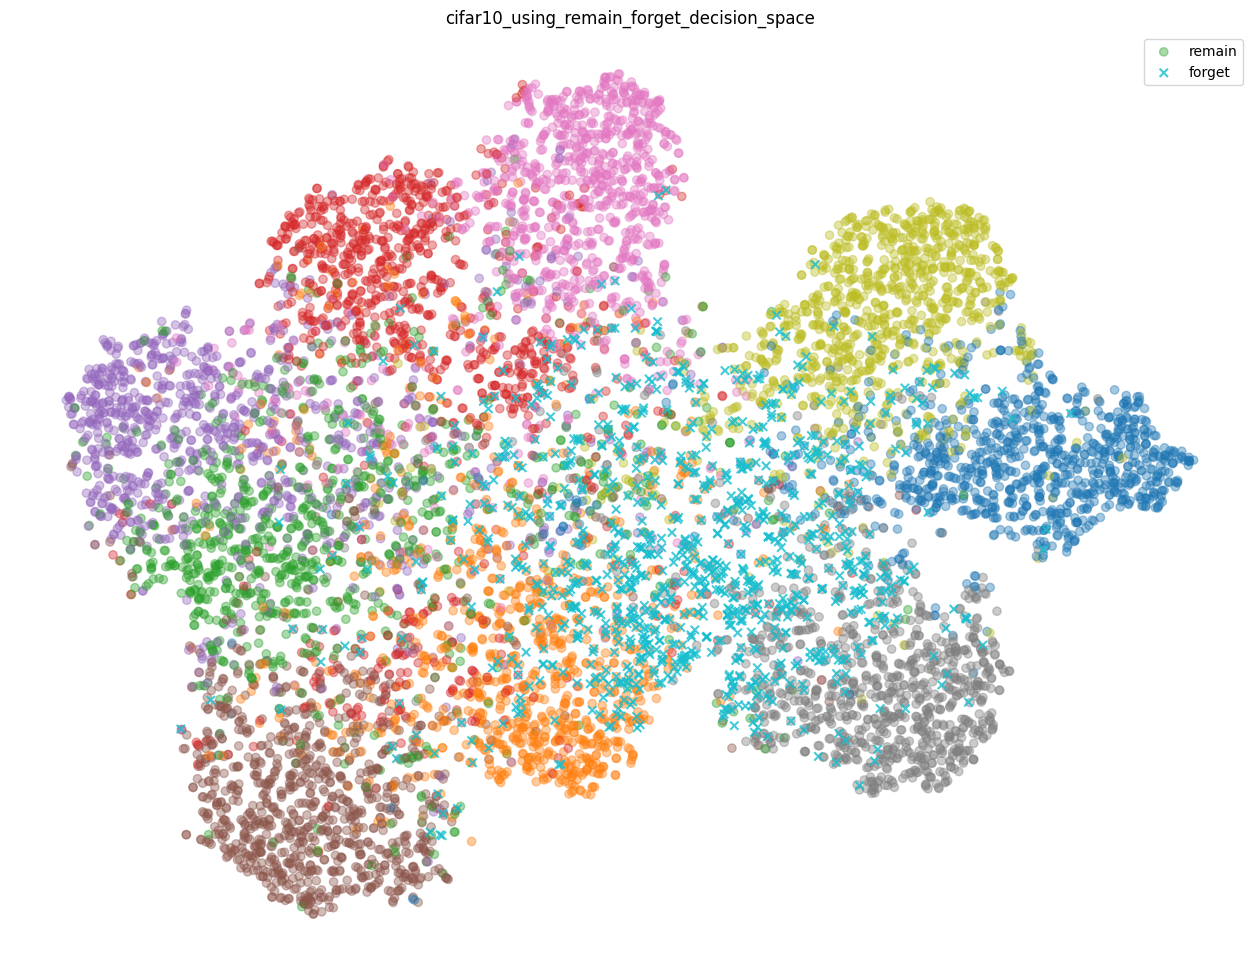

In [20]:
# 모델 선언
model = ResNet18().to(device)

# pt를 저장하기 위한 폴더 생성
pt_folder_name = 'Boundary_Unlearning_task1_pt'
os.makedirs(pt_folder_name, exist_ok = True)

# 모델의 가장 높은 정확도를 기록하기 위한 변수
best_accuracy = 0.

# 분류 문제에서 자주 사용하는 손실 함수
criterion = nn.CrossEntropyLoss()

# Stochastic Gradient Descent = 확률 경사 하강법
optimizer = optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9)

# 학습 30 회
for epoch in range(1, 31):
    print("start training epoch ", epoch)
    
    # 학습 모드 설정, loss, 맞춘 수, 사용한 샘플 수
    model.train()
    train_total_loss = 0.
    train_total_count = 0.
    train_total_data = 0
    
    # 학습 데이터를 배치 단위로 로드, tqdm으로 진행 상황 출력
    for idx, (images, labels) in enumerate(tqdm(train_remain_loader)):
        # 학습할 device로 보내기 gpu or cpu
        images, labels = images.to(device), labels.to(device)
        
        # 이전 배치에서 계산되 기울기 값 초기화
        optimizer.zero_grad()
        
        # 입력 데이터에 대한 예측
        logit_output = model(images)
        
        # 예측된 출려과 정답 간의 차이 계산
        loss = criterion(logit_output, labels)
        
        # 모델이 예측한 정답
        _, predict = torch.max(logit_output, 1)
        
        # 예측이 실제 정답과 일치하는 수
        check_count = (predict == labels).sum().item()
        
        train_total_loss += loss.item()
        train_total_count += check_count
        train_total_data += len(labels)
        
        # loss에 대한 모델의 가중치의 기울기 계산
        loss.backward()
        # 계산한 기울기를 이용하여 가중치 업데이트
        optimizer.step()
        # 기울기 초기화 후 다음 배치 준비
        model.zero_grad()
        
    # 학습 배치에서의 loss 평균
    train_avg_loss = train_total_loss / len(train_remain_loader)
    # 학습 배치에서의 정확도
    train_accuracy = train_total_count / train_total_data * 100
        
    # 평가 모드 설정, loss, 맞춘 수, 사용한 샘플 수
    model.eval()
    test_total_loss = 0.
    test_total_count = 0.
    test_total_data = 0
    
    # 테스트 데이터를 배치 단위로 로드, tqdm으로 진행 상황 출력
    for idx, (images, labels) in enumerate(tqdm(test_remain_loader)):
        # 학습할 device로 보내기 gpu or cpu
        images, labels = images.to(device), labels.to(device)
        
        # 기울기 계산을 사용하지 않음
        with torch.no_grad():
            # 테스트 데이터로 모델의 예측값을 얻음
            logit_output = model(images)
            
            # 예측과 정답 사이의 loss 계산
            loss = criterion(logit_output, labels)
            
            # 모델이 예측한 정답을 얻음
            _, predict = torch.max(logit_output, 1)
            
            # 맞춘 샘플 수
            check_count = (predict == labels).sum().item()
            
            test_total_loss += loss.item()
            test_total_count += check_count
            test_total_data += len(labels)
            
    # 테스트 데이터에 대한 loss 평균
    test_avg_loss = test_total_loss / len(test_remain_loader)
    # 테스트 데이터에 대한 정확도
    test_accuracy = test_total_count / test_total_data * 100
    
    print(f"[epoch][{epoch} / 30], train_loss : {train_avg_loss:.4f}, train_accuracy : {train_accuracy:.4f}, test_loss : {test_avg_loss:.4f}, test_accuracy : {test_accuracy:.4f}%")
    
    # 테스트 데이터가 가장 높은 경우 모델 저장
    if test_accuracy > best_accuracy:
        print(f"new acc : {test_accuracy:.2f}%, save model !")
        best_accuracy = test_accuracy
        
        # 모델의 가중치를 지정된 경로에 저장
        model_save_path = os.path.join(pt_folder_name, f"resnet18_best_retrain.pt")
        torch.save(model.state_dict(), model_save_path)
            
    # train_forgetset에 대해 모델 성능 평가
    train_forget_correct = 0
    train_forget_total = 0
    
    print("start forget_training epoch ", epoch)
    # forget train 데이터를 배치 단위로 로드, tqdm으로 진행 상황 출력
    for idx, (images, labels) in enumerate(tqdm(train_forget_loader)):
        images, labels = images.to(device), labels.to(device)
        
        # 기울기 계산을 사용하지 않음
        with torch.no_grad():
            # forget train 데이터로 모델의 예측값을 얻음
            logit_output = model(images)
            
            # 모델이 예측한 정답을 얻음
            _, predict = torch.max(logit_output, 1)
            
            # 맞춘 샘플 수
            train_forget_correct += (predict == labels).sum().item()
            train_forget_total += len(labels)
            
    # forget train 데이터에 대한 정확도
    train_forget_accuracy = train_forget_correct / train_forget_total * 100
    
    # test_forgetset에 대한 모델 성능 평가
    test_forget_correct = 0
    test_forget_total = 0
    
    # forget test 데이터를 배치 단위로 로드, tqdm으로 진행 상황 출력
    for idx, (images, labels) in enumerate(tqdm(test_forget_loader)):
        images, labels = images.to(device), labels.to(device)
        
        # 기울기 계산을 사용하지 않음
        with torch.no_grad():
            # forget test 데이터로 모델의 예측값을 얻음
            logit_output = model(images)
            # 모델이 예측한 정답을 얻음
            _, predict = torch.max(logit_output, 1)
            
            # 맞춘 샘플 수
            test_forget_correct += (predict == labels).sum().item()
            test_forget_total += len(labels)
    
    # forget test 데이터에 대한 정확도        
    test_forget_accuracy = test_forget_correct / test_forget_total * 100
    
    print(f"forgetset - train accuracy : {train_forget_accuracy:.2f}%, test accuracy: {test_forget_accuracy:.2f}")
    
    # 시각화
    if epoch == 10 or epoch == 20 or epoch == 30:
        print(f'visualization decision space {epoch}')
        remain_embs, remain_labels = extract_emb(model, test_remain_loader, device)
        forget_embs, forget_labels = extract_emb(model, test_forget_loader, device)
        # visualization_emb_retrain(embs, labels)
        visualization_emb_com(remain_embs, forget_embs, remain_labels, forget_labels)

